In [14]:
%matplotlib nbagg
import os
from tools import *

<IPython.core.display.Javascript object>


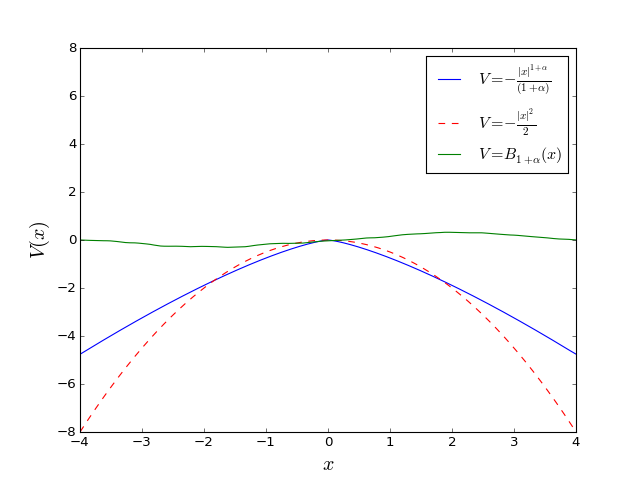

In [15]:
################################################################################
############################### Plots Potentials ###############################
################################################################################

def PlotPotential(Vpara = None,
                  Vcusp = None,
                  Vfbm = None,
                  xmax = 10):
    xfine = np.arange(-xmax, xmax, 2.*xmax/Vfbm.shape[0]).astype(np.float)
    maximum =  max(np.max(abs(Vpara)), np.max(abs(Vcusp)), np.max(abs(Vfbm)))
    ax = plt.figure().add_subplot(111)
    ax.plot(xfine,
            Vcusp,'b-',
            label = '$V =  -\\frac{|x|^{1+ \\alpha}}{(1+\\alpha)}$')
    ax.plot(xfine,
            Vpara,'r--',
            label = '$V = -\\frac{|x|^{2}}{2}$')
    ax.plot(xfine,
            Vfbm,'g',
            label = '$V = B_{1+\\alpha}(x)$')
    ax.legend(loc = "best")
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-maximum, maximum)
    ax.set_xlabel('$x$', fontsize = 18)
    ax.set_ylabel('$V(x)$', fontsize = 18)

ell = 100
n = 1e5
a = 1/3.
xmax = 4

Vfbm =  0.2*SmoothedBrownianPotential(ell, n, e, rseed = 11)
xfine = np.arange(-xmax, xmax, 2.*xmax/Vfbm.shape[0]).astype(np.float)
Vpara =  InvertedOscillatorPotential(xfine)
Vcusp = SmoothConicalPotential(ell, xfine, a)
PlotPotential(Vpara = Vpara,
              Vcusp = Vcusp,
              Vfbm = Vfbm,
              xmax = xmax)

Solving Schroedinger
-----

We supply the Schoedinger equation with initial data in the form of a minimal uncertainty wavepacket
$$\psi_0(x;x_0) = \frac{1}{(2\pi)^{1/4}\sigma^{1/2}}\exp\left(-\frac{|x-x_0|^2}{4\sigma^2}\right)e^{i p_0x/\hbar}$$
Note that since $\hat{p}= \hbar/i \partial_x$, we have that $\hat{p}\psi_0(x) = (p_0+ i\hbar x/\sigma^2 )\psi_0(x)$. As "$\hbar\to0$" this corresponds to fixing an initial moment for the "classical particle".


Roughly speaking, this solver uses a split physical-fourier space method.  That is first it solves 
$
i \hbar \partial_t \psi = V\psi 
$
yielding 
$
\psi(x, t+\Delta t) = \psi(x,t)e^{-iV(x) \Delta t/\hbar}.
$

Then, on the fourier side it solve 
$
i \hbar \partial_t \hat{\psi} = \frac{\hbar^2k^2}{2m}\hat{\psi} 
$
yeilding 
$
\hat{\psi}(k, t+\Delta t) = \hat{\psi}(k,t)e^{-i\hbar^2k^2 \Delta t/2m}.
$

Here are more details on algorithm that it uses

1) Discretize wavefunction to a grid $\psi_n(t)= \psi(x_n,t)$, $V_n= V(x_n)$ and $\hat{\psi}_m= \hat{\psi}(k_n,t)$.

2)  Progress the system by step $\Delta t$.  This involves first computing a "half step" in $x$:
$
x: \psi_n \leftarrow \psi_ne^{-iV(x) (\Delta t/2)/\hbar}
$

3) The calculate $\hat{\psi}_m$ from $\psi_n$ via FFT

4)  Computing a "full step" in $k$:
$
k: \hat{\psi}_m \leftarrow \hat{\psi}_m e^{-i\hbar^2k^2 \Delta t/2m}
$

5) Calculate $\psi_n$ from $\hat{\psi}_m$ via inverse FFT

6) Compute second "half-step" in $x$
$
\psi_n \leftarrow \psi_ne^{-iV(x) (\Delta t/2)/\hbar}
$

7) Repeat



In [16]:
#os.system('rm ' + os.getcwd() + '/data/*')
storedData = []

hbarUsed = 2.**(-np.arange(-1, 7, 1))
#hbarUsed = np.array([2**(-1), 2**(-3), 2**(-5), 2**(- 7), 2**(-9)])


def main():
    computator = [GetData(
                      nsteps = 4, #30,
                      resolution = 2**7,
                      hbar = h,
                      timestep = 1.0)
                  for h in hbarUsed]
    for c in computator:
        print('computing for h = {0}'.format(c.hbar))
        suffix = '_{0}_res_{1}'.format(c.hbar, c.resolution)
        storedData.append(
            (c.compute(base_name = 'data/Scone' + suffix,
                       V = SmoothConicalPotential(
                               c.ell, c.x, 1/3.),
                       base_info = {'roughness' : 1/3,
                                    'ell' : c.ell})))#,
#             c.compute(base_name = 'data/Spara' + suffix,
#                       V = InvertedOscillatorPotential(c.x),
#                       base_info = {'roughness' : 2})))

cProfile.run('main()', 'profile')
p = pstats.Stats('profile')
p.sort_stats('cumulative').print_stats(10)
p.sort_stats('time').print_stats(10)

computing for h = 2.0
inside evolve
(4, 128, 0.0078125)
computing for h = 1.0
inside evolve
(4, 256, 0.00390625)
computing for h = 0.5
inside evolve
(4, 512, 0.001953125)
computing for h = 0.25
inside evolve
(4, 1024, 0.0009765625)
computing for h = 0.125
inside evolve
(4, 2048, 0.00048828125)
computing for h = 0.0625
inside evolve
(4, 4096, 0.000244140625)
computing for h = 0.03125
inside evolve
(4, 8192, 0.0001220703125)
computing for h = 0.015625
inside evolve
(4, 16384, 6.103515625e-05)
Mon Jun  1 14:08:54 2015    profile

         37746 function calls (29050 primitive calls) in 1.784 seconds

   Ordered by: cumulative time
   List reduced from 207 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    1.784    1.784 <ipython-input-16-4e49039a8983>:8(main)
        8    0.000    0.000    1.382    0.173 tools.py:166(compute)
        8    0.484    0.061    0.950    0.119 schrodinger.py:310(evolve)
       40

<pstats.Stats instance at 0x10fe2cea8>

Wavefunction Measurement and Dispersion
---

In the case of a free Gaussian wavepacket, we can solve Schroedinger's equation analytically.  The result is the following
\begin{equation}
\psi(x,t) = \frac{1}{\pi^{1/4}\sqrt{\sigma\beta(t)}} e^{i(p_0x-E(p_0)t)/\hbar} e^{-[x-x_0-(p_0/m)t]^2/(2\sigma^2\beta(t))}
\end{equation}
where $\beta(t)= 1 + i\frac{\hbar t}{m \sigma^2}$ and $E(p_0)= p_0^2/2m$. Showing our evolution of a free wavepacket agrees with the analytic form will be a check on our code.  The analytic form for the dispersion for this free wave packet is
\begin{equation}
\Delta x(t) = \frac{\sigma}{\sqrt{2}} \sqrt{1 + \left(\frac{\hbar t}{m \sigma^2}\right)^2}
\end{equation}
On the other hand, for a particle moving in a parabolic potential, the dispersion in the semiclassical limit may be computed analytically via Hagedorn's equations.  This reads
\begin{equation}
\Delta x(t) = \frac{t \sigma}{\sqrt{2}} \cosh(c t)
\end{equation}
where $c$ is (twice) constant in front of the $x^2$ term in of the parabola.

In [55]:
def snapshop_wavefunction(
        tf = 20,
        data = storedData[0],
        minx = -20,
        maxx = 20,
        yheight = 20,
        prefix = 'bla'):
    
    h = data.hbar #if you solve more than one potential at a time, need data[0].hbar
    a =  (h)**(0.5)

    time = np.arange(0, data.dispersion_vs_t.shape[0]).astype(np.float)
    
    ExtCharRight, ExtCharLeft = ExtremalCharacteristics(time, 1/3.)
        
    
    fig = plt.figure(figsize=(10, 4))
    axw = fig.add_subplot(121)
    axd = fig.add_subplot(122)
    for observation_time in time:
        axw.cla()
        axd.cla()
        axw.axvline(ExtCharLeft[observation_time], color = 'black', linestyle='dashed', linewidth=1)
        axw.axvline(ExtCharRight[observation_time], color = 'black', linestyle='dashed', linewidth=1)
        axw.plot(data.x,
                 np.abs(data.psi_x_full[observation_time])**2,'b-',
                 color = 'blue', linestyle='solid', linewidth=1)
        axw.plot(data.x,
                 squared_wavefunctionBARTON(observation_time, data.x, a, h, 1, 0, 1),
                 color = 'red', linestyle='solid', linewidth=1)
#        axw.plot(data[1].x,
#                 np.abs(data[1].psi_x_full[observation_time])**2,'b-',
#                 color = 'green')
#        axw.plot(data[0].x, 
#                 data[0].V_x - 0.45,
#                 color = 'black')
        axw.set_title("$\\hbar$ = {0}".format(h))
        axw.legend(loc = "best")
        axw.set_xlim(minx, maxx)
        axw.set_ylim(0, .1)
        axw.set_xlabel('$x$', fontsize = 18)
        axw.set_ylabel('$\\rho_\\psi(t)$', fontsize = 18)

        axd.plot(time[:observation_time+1],
                (data.dispersion_vs_t[:observation_time+1])**2,
                label = '$V(x) = -\\frac{|x|^{(1+ \\alpha)}}{(1+\\alpha)}$',
                color = 'blue')
#        axd.plot(time[:observation_time+1],
#                (data[1].dispersion_vs_t[:observation_time+1])**2,
#                label = '$V = -\\frac{|x|^2}{2}$',
#                color = 'green')
#        axd.plot(time[:observation_time+1],
#                lineardispersion[:observation_time+1],
#                label = '$V = 0$',
#                color = 'cyan')
#        axd.plot(time, 
#                 free_particle_dispersion(time + 1, a, h, 1),'--',
#                 color = 'green')
        axd.plot(time, 
                 inverted_oscillator_dispersion(time, a, h, 1, 1),
                 label = '$V(x) = -\\frac{|x|^2}{2}$',
                 color = 'red')
        axd.set_title("$\\hbar$ = {0}".format(h))
        axd.set_xlim(0, tf)
        axd.set_ylim(0, yheight)
        axd.legend(loc = "best")
        axd.set_xlabel('$t$', fontsize = 18)
        axd.set_ylabel('$|\\Delta_\\psi(t)|^2$', fontsize = 18)
        fig.savefig('figs/' + prefix + '_frame_{0:0>2}.png'.format(observation_time),
                    format = 'png')
    subprocess.call(['convert', 'figs/' + prefix + '_frame*.png', 'movies/' + prefix + '.gif'])

#### We calculate the dispersion of the wavefuntion $\psi(t)$ in the following way: \begin{equation} \Delta_{\psi}(t) = \left(\int_{\mathbb{R}} \psi(t)^* x^2\psi(t) {\rm d} x - \left|\int_{\mathbb{R}} \psi(t)^* x \psi(t) {\rm d} x \right|^2 \right)^{1/2} \end{equation}

<IPython.core.display.Javascript object>


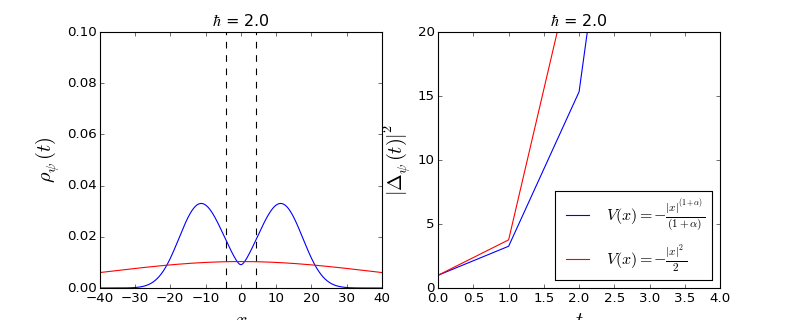

<IPython.core.display.Javascript object>


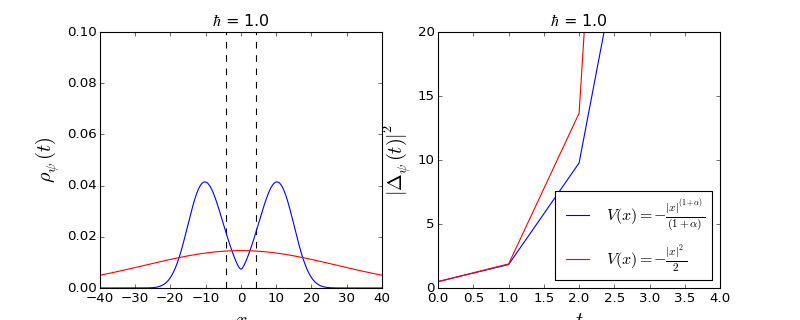

<IPython.core.display.Javascript object>


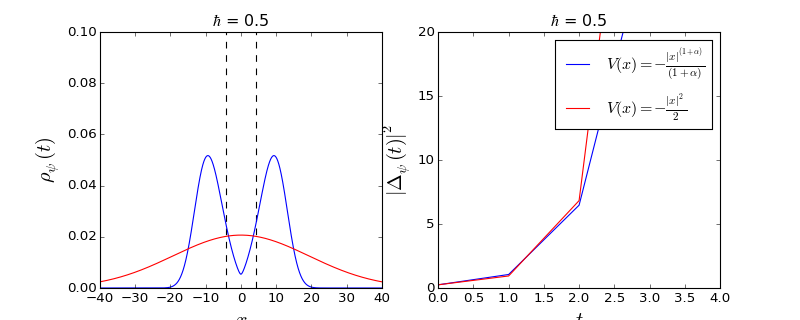

<IPython.core.display.Javascript object>


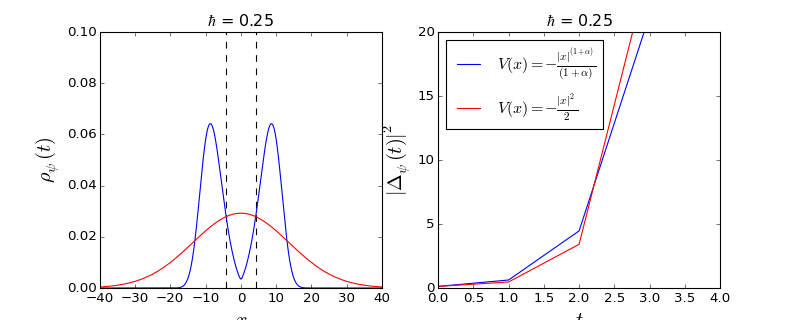

<IPython.core.display.Javascript object>


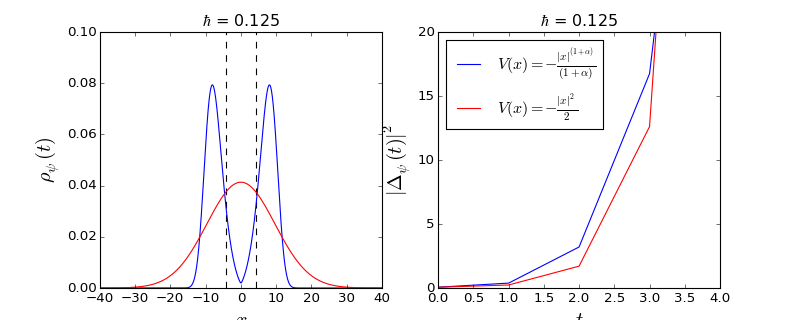

<IPython.core.display.Javascript object>


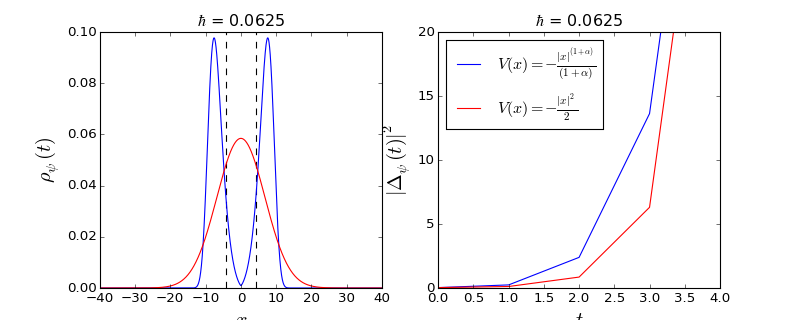

<IPython.core.display.Javascript object>


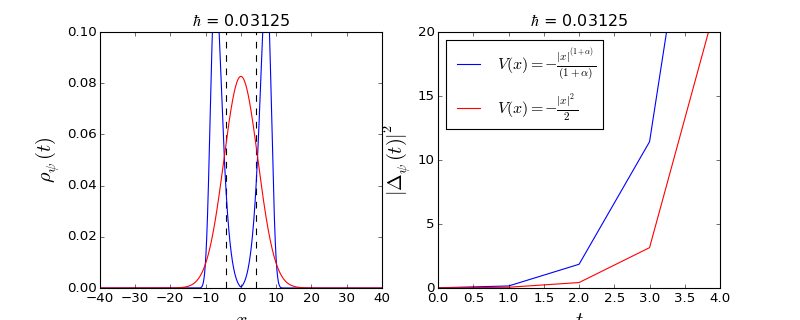

<IPython.core.display.Javascript object>


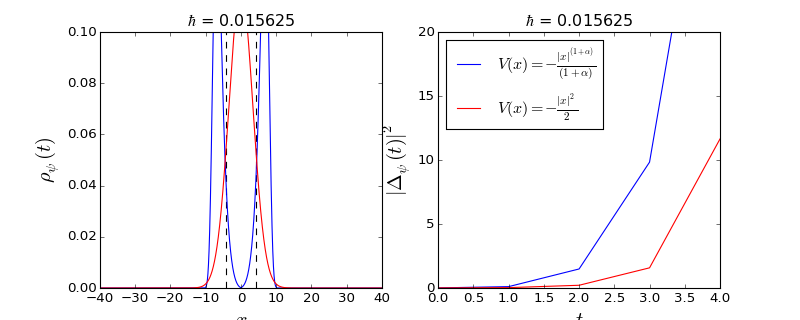

In [56]:
def plotResults(T = 4, domainsize = 40, yH = 20):
    for i in range(len(storedData)):
        snapshop_wavefunction(prefix = 'Evolution_for_hbar_{0}'.format(hbarUsed[i]),
                              tf = T,
                              data = storedData[i],
                              minx = -domainsize,
                              maxx = domainsize,
                              yheight = yH)
    return None
plotResults()

<IPython.core.display.Javascript object>


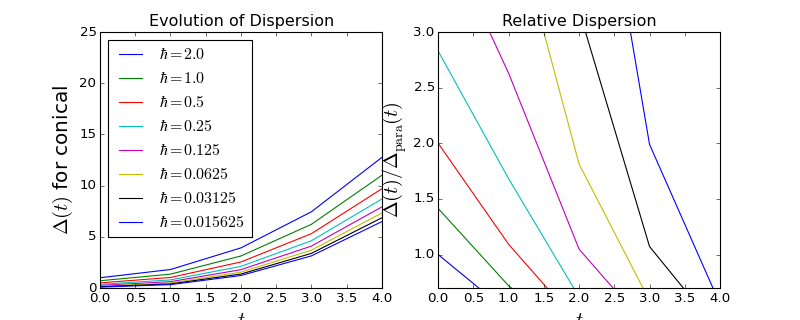

In [67]:
def dispersionMultipleH(yH = 20):
    time = np.arange(0, storedData[0].dispersion_vs_t.shape[0]).astype(np.float)
    labels = ['conical','parabola']
    #fig = plt.figure(figsize=(12, 12))
    for j in range(1):
        #ax = fig.add_subplot(22{0}).format(j+1)
        fig = plt.figure(figsize=(10, 4))
        for i in range(len(storedData)):
            ax = fig.add_subplot(121)
            ax.plot(time,
                    storedData[i].dispersion_vs_t,
                    label = '$\hbar = {0}$'.format(storedData[i].hbar))
            ax.set_xlim(0, storedData[0].dispersion_vs_t.shape[0]-1)
            ax.set_ylim(0, yH)
            ax.legend(loc = "best")
            ax.set_xlabel('$t$', fontsize = 18)
            ax.set_ylabel('$\\Delta(t)$ for {0}'.format(labels[j]), fontsize = 18)
            ax.set_title("Evolution of Dispersion")
            ax = fig.add_subplot(122)
            ax.plot(time,
                    storedData[i].dispersion_vs_t/inverted_oscillator_dispersion(time, (storedData[i].hbar)**(0.5), storedData[i].hbar, 1, 1))
            ax.set_xlim(0, storedData[0].dispersion_vs_t.shape[0]-1)
            ax.set_ylim(.7, 3)
            ax.legend(loc = "best")
            ax.set_xlabel('$t$', fontsize = 18)
            ax.set_ylabel('$\\Delta(t)/\\Delta_{{\\rm para}}(t)$', fontsize = 18)
            ax.set_title("Relative Dispersion")
            #plt.gcf().savefig('dispersionStudy{0}.pdf'.format(j), format = 'pdf')
    return None
dispersionMultipleH(yH = 25)

[162.51795717009648, 121.0993788338957, 93.861715336464215, 75.468418221708362, 62.708617444312559, 53.619384014182891, 46.976606670798127, 42.000745798270152]


<IPython.core.display.Javascript object>


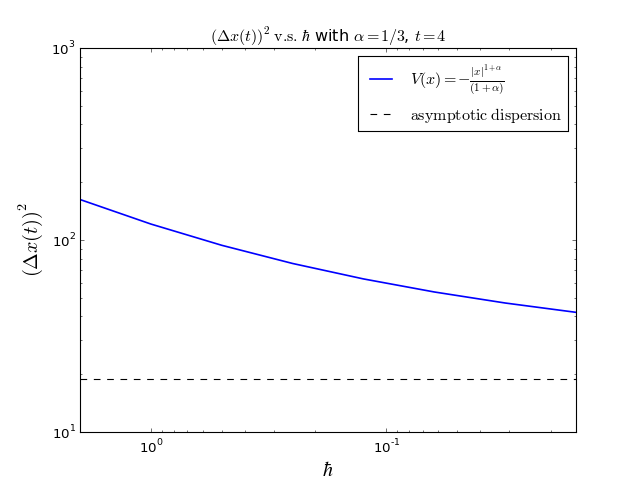

In [81]:
def dispersionFunctionOfHbar(alpha = 1/3.):
    finaltimedispersion =  [0 for i in range(len(storedData))]# for i in range(2)]
    tf = storedData[0].dispersion_vs_t.shape[0]-1
    tf = 4
    
    paraboladispersion = inverted_oscillator_dispersion(tf, (hbarUsed)**(0.5), hbarUsed, 1 ,1)

    for i in range(len(storedData)):
        finaltimedispersion[i] = (storedData[i].dispersion_vs_t[tf])**2
        #finaltimedispersion[1][i] = (storedData[i][1].dispersion_vs_t[tf])**2
    #finaltimedispersion[0][:]/=finaltimedispersion[0][0]
    #finaltimedispersion[1][:]/=finaltimedispersion[1][0]
    print finaltimedispersion
    asymptdisp =  [pure_cusp_dispersion(tf, 1/3.) for i in range(len(hbarUsed))]
    ax = plt.figure().add_subplot(111)
    #for j in range(len(finaltimedispersion)):
    ax.plot(hbarUsed,
            finaltimedispersion, color = 'blue', linestyle='solid', linewidth=1.5,
            label = '$V(x) = -\\frac{|x|^{1+ \\alpha}}{(1+\\alpha)}$')
    ax.plot(hbarUsed,
            asymptdisp, '--k', color = 'black', linestyle='dashed', linewidth=1,
           label = '$ \\rm asymptotic \ dispersion$')
    #ax.plot(hbarUsed,
    #        paraboladispersion, '--k', color = 'red', linestyle='solid', linewidth=1.5, 
    #        label = '$V(x) = -\\frac{|x|^{2}}{2}$')
    ax.set_xlim(hbarUsed[-1], hbarUsed[0])
    #ax.set_ylim(0, 800)
    ax.legend(loc = "best")
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xscale('log')
    ax.set_xlabel('$\\hbar$', fontsize = 18)
    ax.set_ylabel('$(\\Delta x(t))^2$', fontsize = 18)
    ax.set_yscale('log')
    ax.set_title("$(\\Delta x(t))^2 {\\rm v.s.\ } \\hbar$ with $\\alpha = 1/3$, $t = 4$")
    #plt.gcf().savefig('hbar_scaling.pdf', format = 'pdf')
    return None
dispersionFunctionOfHbar(1/3.)

In [31]:
def Probability(t = 2):
    ProbCone = [0 for i in range(len(storedData))]
    #ProbPara = [0 for i in range(len(storedData))]
    for i in range(len(storedData)):
        ProbCone[i] = np.sum((np.abs(storedData[i].psi_x_full[t])**2)*storedData[i].dx)
        #ProbPara[i] = np.sum((np.abs(storedData[i][1].psi_x_full[t])**2)*storedData[i][1].dx)
    return ProbCone#, ProbPara
Probability(t = 4)

[1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0000000000000002,
 1.0000000000000002]

In [34]:
hbarUsed = np.array([2**(0), 2**(-1), 2**(-2), 2**(-3), 2**(-4)])

def get_dispersion_vs_h(
        hlist = [],
        prefix = 'Scone'):
    d = []
    for h in hlist:
        suffix = '_{0}_res_{1}'.format(h, 2**6)
        print ('reading data for ' + prefix + suffix)
        c = read_solution(base_name = 'data/' + prefix + suffix)
        print(dir(c))
        d.append(c.dispersion_vs_t[20])
    return np.array(d)

dcone = get_dispersion_vs_h(hlist = hbarUsed,
                            prefix = 'Scone')
dfree = get_dispersion_vs_h(hlist = hbarUsed,
                            prefix = 'Sfree')
dpara = get_dispersion_vs_h(hlist = hbarUsed,
                            prefix = 'Spara')


ax = plt.figure().add_subplot(111)
ax.plot(hbarUsed, dcone)
ax.plot(hbarUsed, dfree)
ax.plot(hbarUsed, dpara)
ax.plot(hbarUsed, hbarUsed**(-1))
# ax.plot(hbarUsed, hbarUsed**(-0.5))
# ax.set_xlim(0, 1)
# #ax.set_ylim(0, 800)
# ax.legend(loc = "best")
# ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xscale('log')
# ax.set_xlabel('$\\hbar$', fontsize = 18)
# ax.set_ylabel('$|\\Delta(t_f)|^2$', fontsize = 18)
ax.set_yscale('log')
# ax.set_title("Scaling with $\\hbar$ of dispersion at time $t_f$")

reading data for Scone_1.0_res_64
['__doc__', '__init__', '__module__']


AttributeError: read_solution instance has no attribute 'dispersion_vs_t'